In [13]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter as sg
from sklearn.preprocessing import MinMaxScaler

In [14]:
def filtering(dataset):
    try:
        for column in dataset.columns:
            try:
                dataset[column] = sg(dataset[column], window_length=5, polyorder=3)
            except Exception as e:
                print(e)
        return dataset
    except:
        print('Error in smoothing dataframe.')

def normalize(a, min_a=None, max_a=None):
    if min_a is None: min_a, max_a = np.min(a, axis=0), np.max(a, axis=0)
    return (a - min_a) / (max_a - min_a + 0.0001), min_a, max_a

def load_data(from_index, to_index):
    scaler = MinMaxScaler()
    split_rate = 0.75
    dataset_folder = 'data/raw/ENERGY'
    ls = pd.read_excel(os.path.join(dataset_folder, 'labels.xlsx'))
    dataset = pd.read_csv(os.path.join(dataset_folder, 'energy_consumption_hourly.csv'))
    dataset = dataset[from_index:to_index]
    dataset.reset_index(drop=True, inplace=True)
    dataset = filtering(dataset)
    train = dataset.loc[:dataset.shape[0] * split_rate - 1]
    test = dataset.loc[dataset.shape[0] * split_rate:]
    train, test = train.values[0:, 1:].astype(float), test.values[0:, 1:].astype(float)
    train, min_a, max_a = normalize(train)
    test, _, _ = normalize(test, min_a, max_a)
    ls = ls.values[:, 0].astype(int)
    labels = np.zeros_like(test)
    for i in range(-50, 50):
        labels[ls + i, :] = 1
    return train, test, labels

In [15]:
folder = 'data/processed/ENERGY/filtered/dev1/'
train, test, labels = load_data(0, 7000)
for file in ['train', 'test', 'labels']:
    os.makedirs(folder, exist_ok=True)
    np.save(os.path.join(folder, f'{file}.npy'), eval(file))

folder = 'data/processed/ENERGY/filtered/dev2/'
train, test, labels = load_data(7000, 14000)
for file in ['train', 'test', 'labels']:
    os.makedirs(folder, exist_ok=True)
    np.save(os.path.join(folder, f'{file}.npy'), eval(file))
    
folder = 'data/processed/ENERGY/filtered/dev3/'
train, test, labels = load_data(14000, 21000)
for file in ['train', 'test', 'labels']:
    os.makedirs(folder, exist_ok=True)
    np.save(os.path.join(folder, f'{file}.npy'), eval(file))
    
folder = 'data/processed/ENERGY/filtered/dev4/'
train, test, labels = load_data(21000, 28000)
for file in ['train', 'test', 'labels']:
    os.makedirs(folder, exist_ok=True)
    np.save(os.path.join(folder, f'{file}.npy'), eval(file))
    
folder = 'data/processed/ENERGY/filtered/dev5/'
train, test, labels = load_data(28000, 35000)
for file in ['train', 'test', 'labels']:
    os.makedirs(folder, exist_ok=True)
    np.save(os.path.join(folder, f'{file}.npy'), eval(file))

In [10]:
def load_data_no_filter(from_index, to_index):
    scaler = MinMaxScaler()
    split_rate = 0.75
    dataset_folder = 'data/raw/ENERGY'
    ls = pd.read_excel(os.path.join(dataset_folder, 'labels.xlsx'))
    dataset = pd.read_csv(os.path.join(dataset_folder, 'energy_consumption_hourly.csv'))
    dataset = dataset[from_index:to_index]
    dataset.reset_index(drop=True, inplace=True)
    train = dataset.loc[:dataset.shape[0] * split_rate - 1]
    test = dataset.loc[dataset.shape[0] * split_rate:]
    train, test = train.values[0:, 1:].astype(float), test.values[0:, 1:].astype(float)
    train, min_a, max_a = normalize(train)
    test, _, _ = normalize(test, min_a, max_a)
    ls = ls.values[:, 0].astype(int)
    labels = np.zeros_like(test)
    for i in range(-50, 50):
        labels[ls + i, :] = 1
    return train, test, labels

In [11]:
filtered, _, _ = load_data(0, 15000)
original, _, _ = load_data_no_filter(0, 15000)

could not convert string to float: '2006-12-16 17:00:00'


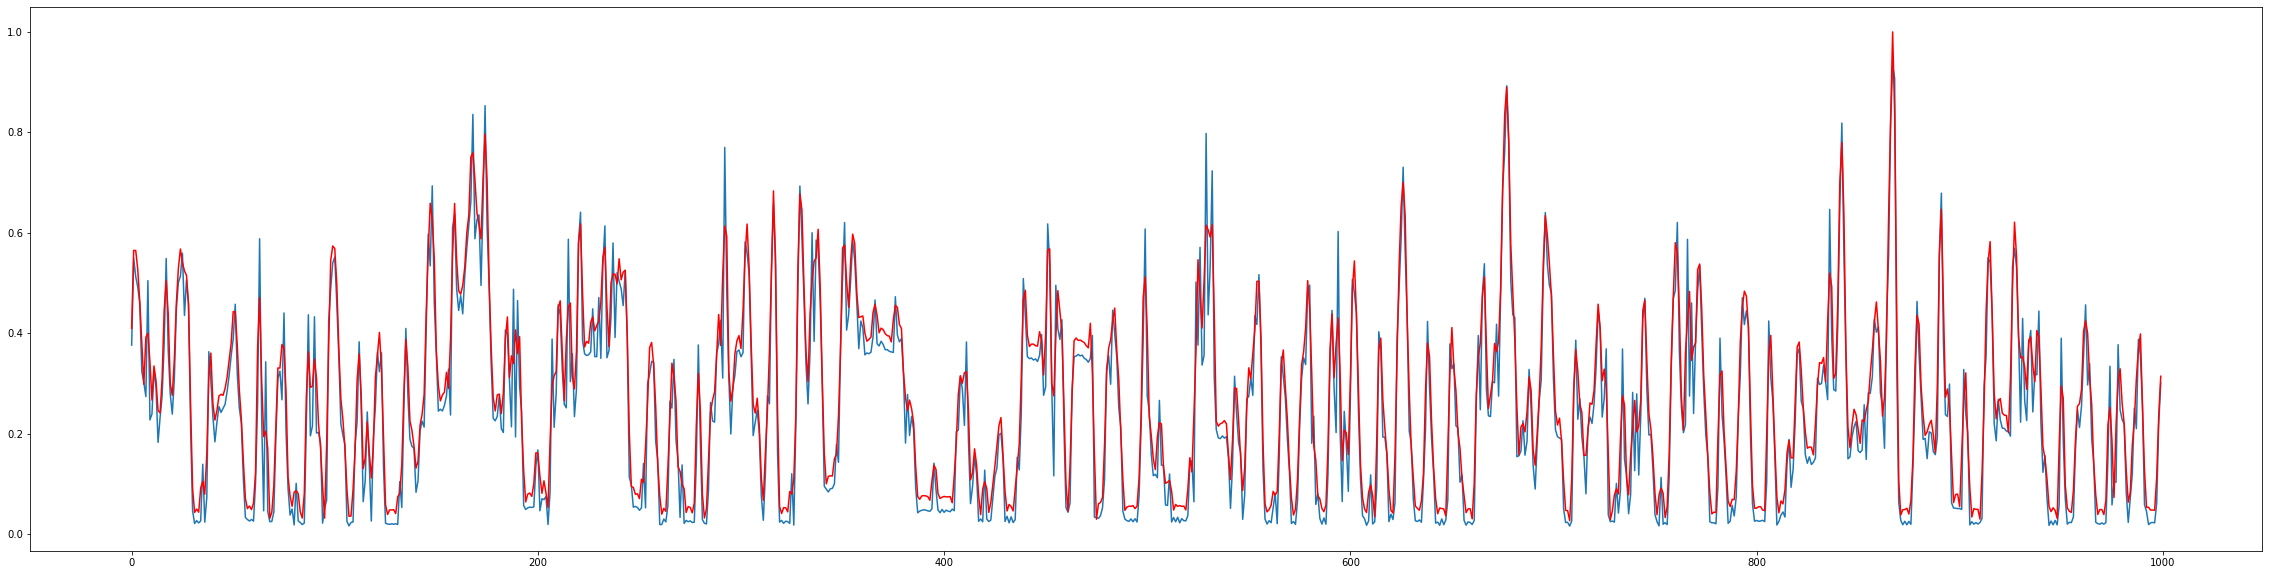

In [12]:
plt.figure(figsize=(40, 10))
plt.plot(original[:, 0][:1000], label='original')
plt.plot(filtered[:, 0][:1000], label='filtered', color='r')
# plt.plot(original[:, 0], label='original')
# plt.plot(filtered[:, 0], label='filtered', color='r')
plt.show()